# Validation of method

### Table of contents

1. [**Schematic of models**](#schem)
2. [**Synthetic**](#syn)
3. [**Biophysical**](#bio)
4. [**Place cells regression**](#place)
5. [**Place cells comodulation**](#corr)

In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np



import equinox
import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as jr
from jax.nn import softplus

import optax

jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)
#jax.config.update("jax_enable_x64", True)

#import os
#if not os.path.exists('./saves'):
#    os.makedirs('./saves')


import pickle


import sys
sys.path.append("..")
import lib


import matplotlib.pyplot as plt
plt.style.use(['../paper.mplstyle'])


import os
if not os.path.exists('./output'):
    os.makedirs('./output')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Schematic of model

In [2]:
# animal position
x_dims = 2
num_samps = 1
prng_state = jax.random.PRNGKey(123)

jitter = 1e-6


var_x = 1.0*np.ones((x_dims))  # GP variance
len_x = 1.0*np.ones((x_dims, 1))  # GP lengthscale

kernx = lib.GP.kernels.Matern52(x_dims, variance=var_x, lengthscale=len_x)


# site_init
Tsteps = 4
site_locs = np.linspace(0.0, 1., Tsteps)  # s
site_obs = 0. * np.ones([Tsteps, x_dims, 1]) + 0*np.random.randn(Tsteps, x_dims, 1)
site_Lcov = 0.01 * np.eye(x_dims)[None, ...].repeat(Tsteps, axis=0)

state_space = lib.GP.markovian.GaussianLTI(
    kernx, site_locs, site_obs, site_Lcov, diagonal_site=True, fixed_grid_locs=False)


evalsteps = 1000
t_eval = jnp.linspace(0.0, 10.0, evalsteps)
pos_prior_samples = state_space.sample_prior(
    prng_state, num_samps, t_eval, jitter)


<a id='svgp'></a>
## SVGP

### 2D

In [3]:
x_dims = 2
f_dims = 3

jitter = 1e-12

n_samp = 10

prng_state = jax.random.PRNGKey(123)

In [109]:
var_t = 1.0*np.ones((f_dims))  # GP variance
len_t = 0.3*np.ones((f_dims, 1))  # GP lengthscale
kernt = lib.GP.kernels.Matern52(f_dims, variance=var_t, lengthscale=len_t)

len_fx = 1.0*np.ones((f_dims, x_dims-1))  # GP lengthscale
var_f = 1.*np.ones(f_dims)  # observation noise
kernx = lib.GP.kernels.SquaredExponential(f_dims, variance=var_f, lengthscale=len_fx)

kern = lib.GP.kernels.Product([kernt, kernx], [[0], list(range(1, x_dims))])


### inducing points ###
num_induc = 20
induc_locs = jax.random.normal(prng_state, shape=(f_dims, num_induc, x_dims))

prng_state, _ = jr.split(prng_state)


mode = 'qSVGP'
if mode == 'qSVGP':
    u_mu = 0. + 1.*jax.random.normal(prng_state, shape=(f_dims, num_induc, 1))
    u_Lcov = 0.1*jnp.eye(num_induc)[None, ...].repeat(f_dims, axis=0)
    
    svgp = lib.GP.sparse.qSVGP(kern, induc_locs, u_mu, u_Lcov, RFF_num_feats=100)
    
    Kzz = svgp.kernel.K(svgp.induc_locs, None, False)
    lambda_1, chol_Lambda_2 = lib.GP.sparse.t_from_q_svgp_moments(Kzz, u_mu, u_Lcov)
    
elif mode == 'tSVGP':
    lambda_1 = 1. + 0.*jax.random.normal(prng_state, shape=(f_dims, num_induc, 1))
    chol_Lambda_2 = 100.*jnp.eye(num_induc)[None, ...].repeat(f_dims, axis=0)
    
    svgp = lib.GP.sparse.tSVGP(kern, induc_locs, lambda_1, chol_Lambda_2, RFF_num_feats=100)
    
    Kzz = svgp.kernel.K(svgp.induc_locs, None, False)
    u_mu, u_Lcov = lib.GP.sparse.t_to_q_svgp_moments(Kzz, lambda_1, chol_Lambda_2, jitter)

In [110]:
prng_state, _ = jr.split(prng_state)

xx = np.meshgrid(*[np.linspace(-3, 3, 30) for _ in range(x_dims)])
xx = jnp.stack(xx, axis=-1)

or_shape = xx.shape[:-1]
xx = xx.reshape(1, 1, -1, x_dims)  # (samp, out_dims, evals, x_dim)
xx_samp = xx.repeat(n_samp, axis=0)

pf_x = svgp.sample_prior(prng_state, xx_samp, jitter)  # (samp, f_dim, evals)
pf_x = pf_x.reshape(n_samp, f_dims, *or_shape)

qf_x, KL = svgp.sample_posterior(prng_state, xx_samp, jitter, compute_KL=True)  # (samp, f_dim, evals)
qf_x = qf_x.reshape(n_samp, f_dims, *or_shape)

qf_m, qf_c, _, _ = svgp.evaluate_posterior(
    xx, mean_only=False, diag_cov=True, compute_KL=False, compute_aux=False, jitter=0.)

qf_m = qf_m.reshape(f_dims, *or_shape)
qf_c = qf_c.reshape(f_dims, *or_shape)

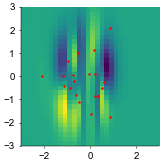

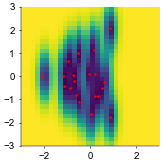

In [111]:
trs = [2, 3]
n = 0

plt.imshow(qf_m[n, ...], extent=[-3, 3, -3, 3], origin='lower', cmap='viridis')
plt.scatter(induc_locs[n, :, 0], induc_locs[n, :, 1], marker='.', color='r')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

plt.imshow(qf_c[n, ...], extent=[-3, 3, -3, 3], origin='lower', cmap='viridis')
plt.scatter(induc_locs[n, :, 0], induc_locs[n, :, 1], marker='.', color='r')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

In [112]:
evalsteps = 500
num_samps = 20

cisi_t_eval = jnp.linspace(0.0, 3.0, evalsteps)
isi_cond = None#jnp.ones((f_dims, ISI_orders-1))
x_cond = jnp.ones((x_dims-1,))

# non
wrap_tau = 1.0*np.ones((f_dims,))
refract_tau = 1e-1*np.ones((f_dims,))
refract_neg= -12.
mean_bias = 0.*np.ones((f_dims,))
dt = 1e-3  # s

bnpp = lib.inference.svgp.NonparametricPointProcess(
    svgp, wrap_tau, refract_tau, refract_neg, mean_bias, dt)

ISI_density = bnpp.sample_conditional_ISI(
    prng_state,
    num_samps,
    cisi_t_eval,
    isi_cond, 
    x_cond,
    int_eval_pts=1000,
    num_quad_pts=100,
    prior=True,
    jitter=1e-6, 
)


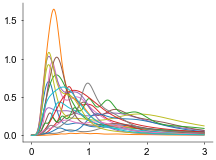

In [113]:
n = 0

plt.plot(cisi_t_eval, ISI_density[:, n, :].T)
plt.show()

## Nonparametric non-renewal process

In [190]:
x_dims = 3
num_samps = 5
prng_state = jax.random.PRNGKey(123)

jitter = 1e-6


### state space GP ###
var_x = 1.0*np.ones((x_dims))  # GP variance
len_x = 0.3*np.ones((x_dims, 1))  # GP lengthscale

kernx = lib.GP.kernels.Matern52(x_dims, variance=var_x, lengthscale=len_x)


num_samps = 20
Tsteps = 1000

site_locs = np.linspace(0., 1., Tsteps)[None, :].repeat(x_dims, axis=0)  # s
site_obs = 0. * np.ones([x_dims, Tsteps, 1]) + 0*np.random.randn(x_dims, Tsteps, 1)
site_Lcov = 1. * np.ones([x_dims, Tsteps, 1]) + 0*np.random.randn(x_dims, Tsteps, 1)


# model
state_space = lib.GP.markovian.IndependentLTI(
    kernx, site_locs, site_obs, site_Lcov, fixed_grid_locs=True)


# evaluate
evalsteps = 2000
t_eval = jnp.linspace(0.0, 1.0, evalsteps)

prior_samples = state_space.sample_prior(
    prng_state, num_samps, t_eval, jitter)


post_mean, post_cov, _ = state_space.evaluate_posterior(
    t_eval, mean_only=False, compute_KL=False, jitter=1e-6)
post_mean = post_mean[..., 0]

post_samples, _ = state_space.sample_posterior(
    prng_state, num_samps, t_eval, jitter, False)  # (tr, time, N, 1)


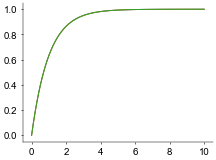

In [187]:
x = np.
bnpp.pp.inverse_link()

SyntaxError: invalid syntax (519808175.py, line 1)

In [252]:
evalsteps = 500
num_samps = 20

cisi_t_eval = jnp.linspace(0.0, 3.0, evalsteps)
isi_cond = None
x_cond = None

# non
wrap_tau = 1.0*np.ones((x_dims,))
refract_tau = 1e0*np.ones((x_dims,))
refract_neg= -0.
mean_bias = 0.*np.ones((x_dims,))
dt = 1e-3  # ms

bnpp = lib.inference.gp.NonparametricPointProcess(state_space, wrap_tau, refract_tau, refract_neg, mean_bias, dt)

nonrefr_renewal_density = bnpp.sample_conditional_ISI(
    prng_state,
    num_samps,
    cisi_t_eval,
    isi_cond, 
    x_cond,
    int_eval_pts=1000,
    num_quad_pts=100,
    prior=True,
)


# refractory
wrap_tau = 1.0*np.ones((x_dims,))
refract_tau = 1e0*np.ones((x_dims,))
refract_neg= -12.
mean_bias = 0.*np.ones((x_dims,))
dt = 1e-3  # ms

bnpp = lib.inference.gp.NonparametricPointProcess(state_space, wrap_tau, refract_tau, refract_neg, mean_bias, dt)

refr_renewal_density = bnpp.sample_conditional_ISI(
    prng_state,
    num_samps,
    cisi_t_eval,
    isi_cond, 
    x_cond,
    int_eval_pts=1000,
    num_quad_pts=100,
    prior=True,
)

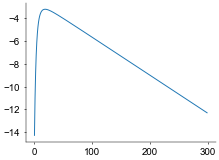

In [24]:
plt.plot(log_rho_t_mean[f_dim, :])

In [9]:
x_eval = None
time_eval = None
ini_spikes = None

ini_t_since = jnp.zeros((num_samps, x_dims))
past_ISIs = None

timesteps = 1000

y_samples, log_rho_ts, x_samples = bnpp.sample_prior(
    prng_state, num_samps, timesteps, x_eval, time_eval, ini_spikes, ini_t_since, past_ISIs, jitter)

TypeError: sample_prior() takes 9 positional arguments but 10 were given

In [253]:
evalsteps = 1000
evals = np.arange(evalsteps)

t_eval = np.zeros(evalsteps)
y = (np.random.randn(evalsteps) > 2.)

ISIs = lib.utils.neural.get_lagged_ISIs(y[:, None], 4, dt)

In [263]:
t_eval = ISIs[:, 0, 0]*100#jnp.linspace(0.0, 100.0, evalsteps)
isi_eval = None
x_eval = None

y = None

log_rho_t_mean, log_rho_t_cov = bnpp.evaluate_log_conditional_intensity(
    prng_state, t_eval, isi_eval, x_eval, jitter
)

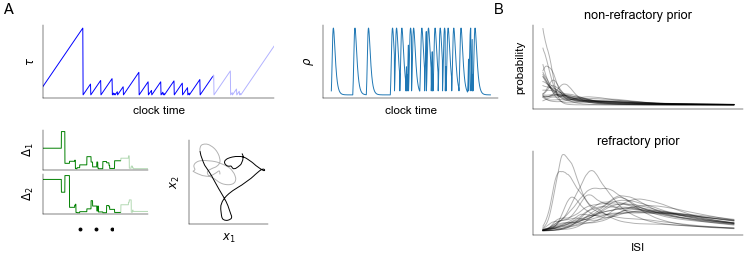

In [271]:
fig = plt.figure(figsize=(10, 3))
fig.text(-0.05, 1.05, 'A', fontsize=15, ha='center')
fig.text(0.65, 1.05, 'B', fontsize=15, ha='center')



widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.65, 
                        left=0.0, right=0.33, wspace=0.1)

ax = fig.add_subplot(spec[0, 0])
T = 800
ax.plot(evals[:T], ISIs[:T, 0, 0], c='b')
ax.plot(evals[T:], ISIs[T:, 0, 0], c='b', alpha=0.3)
ax.set_xlim([250, evalsteps])
ax.set_ylabel(r'$\tau$')
ax.set_yticks([])
ax.set_xlabel('clock time')
ax.set_xticks([])


widths = [1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.5, bottom=0.1, 
                        left=0.0, right=0.15, hspace=0.1)

T = 800
for k in range(2):
    ax = fig.add_subplot(spec[k, 0])
    ax.plot(evals[:T], ISIs[:T, 0, k+1], c='g')
    ax.plot(evals[T:], ISIs[T:, 0, k+1], c='g', alpha=0.3)
    ax.set_xlim([250, evalsteps])
    ax.set_xticks([])
    ax.set_ylim(0)
    ax.set_yticks([])
    ax.set_ylabel('$\Delta_{}$'.format(k+1))


widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.45, bottom=0.05, 
                        left=0.18, right=0.35, wspace=0.0)

ax = fig.add_subplot(spec[0, 0])
T = 500
ax.plot(pos_prior_samples[0, :T, 0], pos_prior_samples[0, :T, 1], c='k')
ax.plot(pos_prior_samples[0, T:, 0], pos_prior_samples[0, T:, 1], alpha=0.3, c='k')
ax.set_aspect('equal')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xticks([])
ax.set_yticks([])


widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.05, bottom=0.0, 
                        left=0.05, right=0.1, wspace=0.0)
ax = fig.add_subplot(spec[0, 0])
ax.scatter(np.arange(3), -10*np.ones(3), c='k')
ax.axis('off')


### intensity ###
widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.65, 
                        left=0.4, right=0.65, wspace=0.1)

ax = fig.add_subplot(spec[0, 0])
ax.plot(np.exp(log_rho_t_mean[0, :]))
ax.set_ylabel(r'$\rho$')
ax.set_xlabel(r'clock time')
ax.set_yticks([])
ax.set_xticks([])



### ISIs ###
widths = [1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.7, right=1.0, hspace=0.5)


n = 0
f_dim = 0

ax = fig.add_subplot(spec[0, 0])
ax.plot(cisi_t_eval, nonrefr_renewal_density[:, f_dim, :].T, c='k', alpha=0.3)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('probability')
ax.set_title('non-refractory prior', fontsize=13)

ax = fig.add_subplot(spec[1, 0])
ax.plot(cisi_t_eval, refr_renewal_density[:, f_dim, :].T, c='k', alpha=0.3)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('ISI')
ax.set_title('refractory prior', fontsize=13)



plt.savefig('output/schematic.pdf')
plt.show()

NameError: name 'an_pos' is not defined

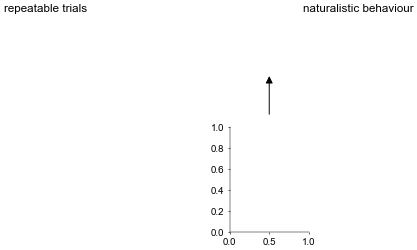

In [85]:
fig = plt.figure(figsize=(8, 3))

fig.text(0.22, 1.05, 'repeatable trials', fontsize=12, ha='center')
fig.text(0.78, 1.05, 'naturalistic behaviour', fontsize=12, ha='center')


    
### behaviour ###


# position
tps = [300, 1000, 1700]
widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, hspace=0.0, 
                        height_ratios=heights, top=0.5, bottom=0.0, 
                        left=0.55, right=1., wspace=0.1)

for k in range(3):
    ax = fig.add_subplot(spec[0, k])
    
    ax.annotate("", xy=(0.5, 1.5), xytext=(0.5, 1.1), rotation=np.pi/2., xycoords='axes fraction', 
                arrowprops=dict(arrowstyle="-|>, head_width=.3, head_length=.6", color='k'), 
                annotation_clip=False)
    
    tp = tps[k]

    x = an_pos[0, 0, tp]
    y = an_pos[0, 1, tp]
    dx = (an_pos[0, 0, tp+1]-an_pos[0, 0, tp])*100
    dy = (an_pos[0, 1, tp+1]-an_pos[0, 1, tp])*100

    ax.scatter(x, y, marker='o', facecolor='k', s=40)
    #ax.arrow(x, y, dx, dy)
    ax.plot(an_pos[0, 0, :tp], an_pos[0, 1, :tp], c='k')
    ax.plot(an_pos[0, 0, tp:], an_pos[0, 1, tp:], c='lightgray')
    ylims = ax.get_ylim()
    ax.set_ylim(-2.4, 2.4)
    ax.set_xlim(-2.4, 2.4)
    ax.set_aspect(1.)
    utils.plot.decorate_ax(ax)
            
            
plt.savefig('output/comparison.pdf')
plt.show()

In [7]:
def get_stat_model(mu, lsigma, log_beta, log_gamma, len_x, kernel_class, neurons):
    """
    """
    f_dims = neurons
    x_dims = f_dims
    
    v_t = 1.*np.ones(neurons)
    v_r = -.3*np.ones(neurons)
    tau_m = 0.01*np.ones(neurons)
    tau_s = np.ones(neurons)
    log_beta = log_beta*np.ones(neurons)
    log_gamma = log_gamma*np.ones(neurons)
    
    tau_h = 0.1*np.ones(neurons)
    a = 1.0*np.ones(neurons)
    b = 1000.0*np.ones(neurons)

    IF_model = lib.IF_models.LIF(log_beta, log_gamma, v_t, v_r, tau_s, tau_m)#, tau_h, a, b)
    
    eps_mapping = lib.mappings.Identity(f_dims)

    ### state space GP ###
    var_x = 1.0*np.ones(x_dims)  # GP variance
    len_x = len_x*np.ones((x_dims, 1))  # GP lengthscale

    kernx = kernel_class(x_dims, variance=var_x, lengthscale=len_x)
    #kernx = lib.kernels.IID(jnp.eye(x_dims))
    
    state_space = lib.GP.state_space.FullLDS(kernx, diagonal_site=True)

    ### mu and sigma ###
    params = {'value': mu*jnp.ones((f_dims,))}
    mu_mapping = lib.mappings.Constant(x_dims, f_dims, params)

    params = {'value': lsigma*jnp.ones((f_dims,))}
    lsigma_mapping = lib.mappings.Constant(x_dims, f_dims, params)
    
    ### initial conditions ###
    q_vh_ic = jnp.zeros((num_samps, neurons, IF_model.q_d))
    
    ### IF GP model ###
    model = lib.inference.IF_SSGP(
        state_space, eps_mapping, mu_mapping, lsigma_mapping, IF_model, q_vh_ic, dtype=jnp.float64)
    return model

NameError: name 'GP' is not defined

In [ ]:
x = np.exp(x)
p = x.numpy()[:, 0, :]*np.exp(-np.cumsum(x.numpy()[:, 0, :], axis=1)*dt) # natural time

In [14]:
t = np.arange(1000)
params = {"t0": 100.}

tau, dtau_dt = time_transform(params, t, inverse=False)
t_, dt_dtau = time_transform(params, tau, inverse=True)

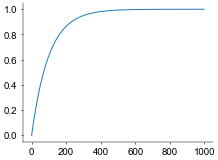

In [15]:
plt.plot(t, tau)

In [ ]:
plt.plot(tau, p.mean(0).T)
plt.plot(tau[:, None].repeat(p.shape[0], axis=1), p.T, alpha=0.3)

In [ ]:
plt.plot(t, p.mean(0).T*dtau_dt)
plt.plot(t[:, None].repeat(p.shape[0], axis=1), p.T*dtau_dt[:, None], alpha=0.3)

In [ ]:
(p*dt).sum(1)

In [ ]:
fig = plt.figure(figsize=(8,5)) # plot fits
fig.text(-0.21, 1.16, 'A', transform=ax.transAxes, size=15)

time_bins = I_ext[0].shape[0]
tt = np.arange(time_bins)*dt



widths = [1]
heights = [1, 1, 1, 2]
spec = fig.add_gridspec(ncols=1, nrows=4, width_ratios=widths, height_ratios=heights, 
                        left=0., right=0.7, bottom=0., top=1.0)

ax = fig.add_subplot(spec[0, 0])